In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union

ee.Initialize()


In [2]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied, currently works for 2000 - 2018
3) Scale (optional): Resolution at which to perform analysis (if not specified, calculated automatically in EE)
4) Satellites / datasets: Queried from Earth Engine, defined in data[sat1...] 
'''

##### AREA #####

# CV
cv = gp.read_file("../shape/cv.shp")
cv_km3 = round(cv.area[0] * 10, 2)* 1000

# HUC 4s draining to the CV 
ssjt = gp.read_file("../shape/cv_hu6.shp")
ssjt2 = ssjt.geometry.simplify(0.1) # This reduces the # of geometries submitted to EE and makes things run mucho faster 
lls = ssjt2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)

# Get the area of the ssjt wshed 
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")
sa_km3 = unary_union([s1.geometry[0], s2.geometry[0], s3.geometry[0]]).area * 10000

##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)


In [62]:
# Read and format data 

In [3]:
cvdf = pd.read_csv("../data/all_data_cv.csv")
df = pd.read_csv("../data/all_data_ssjt.csv")

# Initialize the datetime columns
cvdf['dt'] = pd.to_datetime(df[df.columns[0]])
cvdf = cvdf.set_index(pd.to_datetime(cvdf[cvdf.columns[0]]))
cvdf.drop(cvdf.columns[0],axis = 1, inplace = True)

df['dt'] = pd.to_datetime(df[df.columns[0]])
df = df.set_index(pd.to_datetime(df[df.columns[0]]))
df.drop(cvdf.columns[0],axis = 1, inplace = True)

# Chop off the first n rows of nodata
cvdf = cvdf.iloc[327:]
df = df.iloc[327:]


In [11]:
# Make a modified ET balamce as modis + gmet scaled by area
df['et_acc'] = df['modis'] - cvdf['modis'] + cvdf['et_mean']

# Calc the balance
df['q_out2'] = df['q_out2'].fillna(value = 0)
df['ds'] = df.p_mean - df.et_acc  - df.q_out1 - df.q_out2 - df.soil_moisture.diff() - df.res_s.diff()

In [12]:
# Plot 

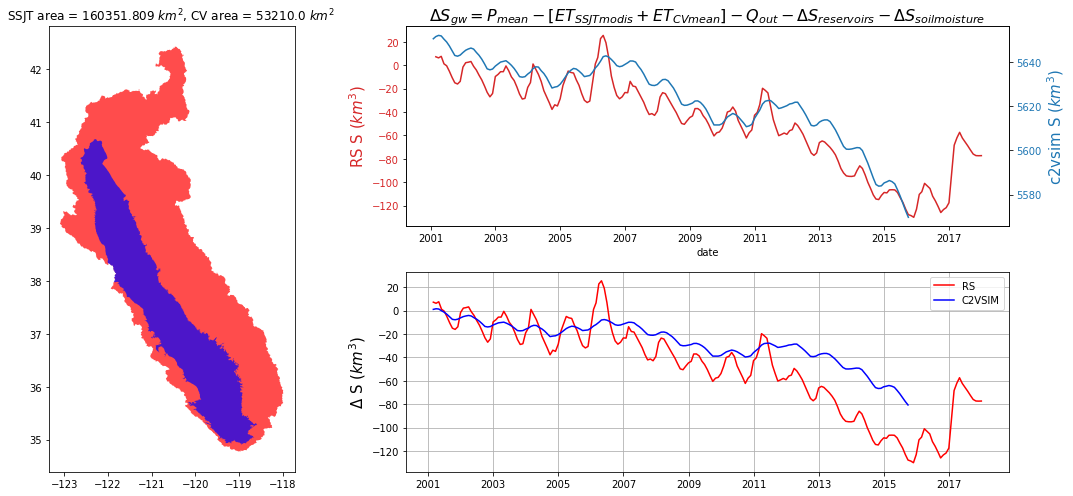

In [18]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_2 = plt.subplot(G[0, 1:])
color = 'tab:red'
axes_2.set_title("$\Delta S_{gw} = P_{mean} - [ET_{SSJT modis} + ET_{CV mean}] - Q_{out} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)

axes_2.set_xlabel('date')
axes_2.set_ylabel('RS S $(km^3)$', color=color, size = 15)
axes_2.plot(df.index[1:], np.cumsum(df.ds[1:]), color=color)
axes_2.tick_params(axis='y', labelcolor=color)

axes_3 = axes_2.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
axes_3.set_ylabel('c2vsim S ($km^3$)', color=color, size = 15) 
axes_3.set_xlabel('date')
axes_3.plot(df.index, df.c2v_s, color=color)
axes_3.tick_params(axis='y', labelcolor=color)

axes_4 = plt.subplot(G[1, 1:])
axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS")
axes_4.plot(df.index[1:], np.cumsum(df.c2v_s.diff()[1:]), color="blue", label = "C2VSIM")
axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.grid(True)
plt.tight_layout()
plt.show()